# Definitions

In [1]:
import os
import numpy as np
import scipy as scp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Set plotting style
sns.set(style='whitegrid', font_scale=2.5, font='serif')
hspace = 0.08
wspace = 0.05

# Constants and conversions
h = 6.62e-34
kB = 1.38e-23
c = 3e8
mm = 1.e-3
GHz = 1.e9
Tcmb = 2.725

In [2]:
# Beam coupling efficiency of Gaussian detector beam pattern
# Args:
#    D_pix (float): pixel diameter/pitch [F-lambda]
#    w_f (float): pixel beam waist factor
def beam_coupling_eff(D_pix, w_f):
    return 1 - np.exp(-(np.pi**2 / 2) * (D_pix / w_f)**2)

# A hexagonal grid of pixels in units of F-lambda
# Args:
#   D_pix (float): pixel diameter/pitch [F-lambda]
#   D_span (float): width/height over which to generate pixel positions [F-lambda]
def hex_pack(D_pix, D_span=8):
    # Generate offsets along horizontal direction
    N = int((D_span / D_pix) // 2)
    x0 = []
    y0 = []
    for n in range(-N-1, N+2):
        if not n%2:
            x0_arr = np.linspace(-(N * D_pix), (N * D_pix), 2*N + 1)
        else:
            x0_arr = np.linspace(-(N * D_pix), (N * D_pix), 2*N + 1) + 0.5 * D_pix
        y0_arr = np.ones(len(x0_arr)) * n * D_pix * (np.sqrt(3) / 2)
        x0.append(x0_arr)
        y0.append(y0_arr)
    x0 = np.array(x0).flatten()
    y0 = np.array(y0).flatten()
    # Isolate unique pairs
    xy0_unique = []
    for pair in np.array([x0, y0]).T:
        found = False
        for xy0 in xy0_unique:
            if np.all(xy0 == pair):
                found = True
                break
            else:
                continue
        if found is False:
            xy0_unique.append(pair)
    return np.array(xy0_unique).T

# VCZT coefficient due to aperture radiation assuming uniform illumination
# Args:
#   D_pix (float): pixel diameter/pitch [F-lambda]
def vczt_apert(D_pix):
    if D_pix == 0:
        return 1
    arg = np.pi * D_pix
    gamma = 2 * scp.special.jv(1, arg) / arg
    return gamma

# VCZT coefficient due to stop radiation assuming uniform illumination
# using the thin-ring approximation
# Args:
#   D_pix (float): pixel diameter/pitch [F-lambda]
#   F (float): F-number at the focal plane
#   D_ap (float): aperture diameter [mm]
#   sigma_ap (float): detector illumination beam width at the aperture [mm]
def vczt_stop(D_pix, F, D_ap, sigma_ap):
    if D_pix == 0:
        return 1
    Fp = (D_ap / (D_ap + 2 * sigma_ap)) * F
    arg = (np.pi * D_pix)
    argp = arg * (F / Fp)
    gamma = (((F**2 * Fp**2) / (F**2 - Fp**2)) * 
             ((1 / Fp**2) * (2 * scp.special.jv(1, argp) / argp) - 
              (1 / F**2) * (2 * scp.special.jv(1, arg) / arg)))
    return gamma

# VZCT correlation coefficients across the focal plane
# Args:
#   x (2D array): x values of points on the focal plane [F-lambda]
#   y (2D array): y values of points on the focal plane [F-lambda]
#   D_pix (float): pixel diameter/pitch [F-lambda]
#   F (float): F-number at the focal plane
#   D_ap (float): diameter of the aperture [mm]
#   w_f (float): pixel Guassian beam waist factor
def vczt_coeffs(x, y, D_pix, F, D_ap, w_f):
    theta_ap = w_f / (np.sqrt(2) * np.pi * D_pix * F)
    sigma_ap = F * D_ap * np.tan(theta_ap)
    # Calculate the stop and aperture correlation coefficients
    # For Stokes Q correlation, every other pixel has coefficient = 0
    corr_ap = [vczt_apert(np.sqrt(x[i]**2 + y[i]**2))
               if i % 2 else 0 for i in range(len(x))]
    corr_st = [vczt_stop(np.sqrt(x[i]**2 + y[i]**2), F, D_ap, sigma_ap) 
               if i % 2 else 0 for i in range(len(x))]
    return corr_ap, corr_st

# Blackbody power spectrum
# Args:
#   freq (float): optical frequency [Hz]
#   T (float) = physical temperature [K]
def bb_pow_spec(freq, T):
    return h * freq / (np.exp(h * freq / (kB * T)) - 1)

# Determine the band over which to integrate
# Args:
#   freq (float): optical frequency [Hz]
#   fbw: fractional bandwidth
def band(freq, fbw):
    flo = freq * (1 - fbw / 2)
    fhi = freq * (1 + fbw / 2)
    return flo, fhi

# Calculate per-detector mapping speed
# Args:
#   band_center (float): detection band center frequency [Hz]
#   fbw (float): detection band fractional bandwidth
#   D_pix (float): pixel diameter/pitch [F-lambda]
#   F (float): F-number at the focal plane
#   w_f (float): pixel Gaussian beam waist factor
#   corr_ap_arr (list): VCZT coefficients across the focal plane due to aperture radiation
#   corr_st_arr (list): VCZT coefficients across the focal plane due to aperture radiation
#   sky_freq (list): atmosphere spectrum's optical frequencies [Hz]
#   sky_temp (list): atmosphere spectrum's physical temperature [Hz]
#   sky_tran (list): atmosphere spectrum's transmissivity [Hz]
#   Tcmb (float): temperature of the CMB [K]
#   Tstop (float): effective temperature of the stop [K]
#   det_eff (float): detector quantum efficiency
#   nepg2 (float): detector thermal noise [W^2 / Hz]
#   nepg2_frac (float): fraction of detector thermal noise to photon noise
def MS_det(band_center, fbw, D_pix, F, w_f, corr_ap_arr, corr_st_arr,
           sky_freq, sky_temp, sky_tran, Tcmb, Ttel, Tstop, det_eff,
           nepg2=None, nepg2_frac=None):
    if nepg2 is not None and nepg2_frac is not None:
        print("Cannot define both Psat frac")
        return
    # Define the observation band
    flo, fhi = band(band_center, fbw)
    freqs = np.linspace(flo, fhi, 10)
    # Calculate the beam coupling efficiency
    ap_eff = beam_coupling_eff(D_pix, w_f)
    st_eff = 1 - ap_eff
    # Interpolate the sky to the detector band frequencies
    Tsky = np.interp(freqs, sky_freq, sky_temp)
    sky_eff = np.interp(freqs, sky_freq, sky_tran)
    # Calculate the power spectrum for each source
    p_cmb = bb_pow_spec(freqs, Tcmb) * sky_eff * ap_eff * det_eff
    p_sky = bb_pow_spec(freqs, Tsky) * ap_eff * det_eff
    p_tel = bb_pow_spec(freqs, Ttel) * ap_eff * det_eff
    p_stop = bb_pow_spec(freqs, Tstop) * st_eff * det_eff
    # Calculate the spectrum within the aperture and outside of it
    p_ap = p_cmb + p_sky + p_tel
    p_st = p_stop
    # Calculate total optical power at the detector
    Popt = np.trapz((p_ap + p_st), freqs)
    # Calculate photon NEP both with and without correlation augmentation
    NEPshot2 = np.trapz((h * freqs * (p_ap + p_st)), freqs)
    NEPbose2_corr = np.trapz(
        np.sum(abs(corr_ap_arr)**2) * p_ap**2 + 
        np.sum(abs(corr_st_arr)**2) * p_st**2 +
        2 * np.sum(np.real(np.conj(corr_ap_arr) * corr_st_arr)) * p_ap * p_st, freqs)
    NEPbose2_noCorr = np.trapz((p_ap + p_st)**2, freqs)
    # Calculate internal detector NEP
    if nepg2 is not None:
        NEPdet2 = nepg2
    elif nepg2_frac is not None:
        NEPdet2 = (NEPshot2 + NEPbose2_noCorr) * nepg2_frac
    else:
        NEPdet2 = 0
    # Calculate total NEP
    NEP2_corr = NEPshot2 + NEPbose2_corr + NEPdet2
    NEP2_noCorr = NEPshot2 + NEPbose2_noCorr + NEPdet2
    # Calculate per-detector band-averaged mapping speed
    tot_eff = sky_eff * ap_eff * det_eff
    MS_corr = np.mean(tot_eff)**2 / NEP2_corr
    MS_noCorr = np.mean(tot_eff)**2 / NEP2_noCorr
    return Popt, NEPshot2, NEPbose2_noCorr, MS_corr, MS_noCorr

In [3]:
# Define the parameters for the system in question
# Wavelength of observation [mm]
lamb = 3. * mm  # 100 GHz
freq = c / lamb
# Aperture diameter [mm]
D_ap = 300. * mm
# F number
F_num = 2.5
# Detector waist factor
w_f = 3

# Example correlation pattern

In [4]:
# Generate a grid of plots for pixel spacings
spacings = [0.2, 0.5, 0.7, 1.0]
Dpix_arr = []
xy_arr = []
gamma_arr = []
for spacing in spacings:
    # Get a hex packed grid of pixels
    Dpix_arr.append(spacing)
    x, y = hex_pack(spacing)
    xy_arr.append([x, y])
    # Get the correlation coefficients
    gammas_ap, gammas_st = vczt_coeffs(x, y, spacing, F_num, D_ap, w_f)
    gamma_arr.append([gammas_ap, gammas_st])

In [5]:
# Delete the central pixel, which will always be 1, and scale the colorbar
xplot_arr = []
yplot_arr = []
gplot_ap_arr = []
gplot_st_arr = []
for i in range(len(spacings)):
    x, y = xy_arr[i]
    gamma_ap, gamma_st = gamma_arr[i]
    xplot = np.array(x).flatten()
    yplot = np.array(y).flatten()
    gplot_ap = np.array(gamma_ap).flatten()
    gplot_st = np.array(gamma_st).flatten()
    xplot_arr.append(xplot)
    yplot_arr.append(yplot)
    gplot_ap_arr.append(gplot_ap)
    gplot_st_arr.append(gplot_st)
cbar_min = -1
cbar_max = 1
linthresh = 1e-3

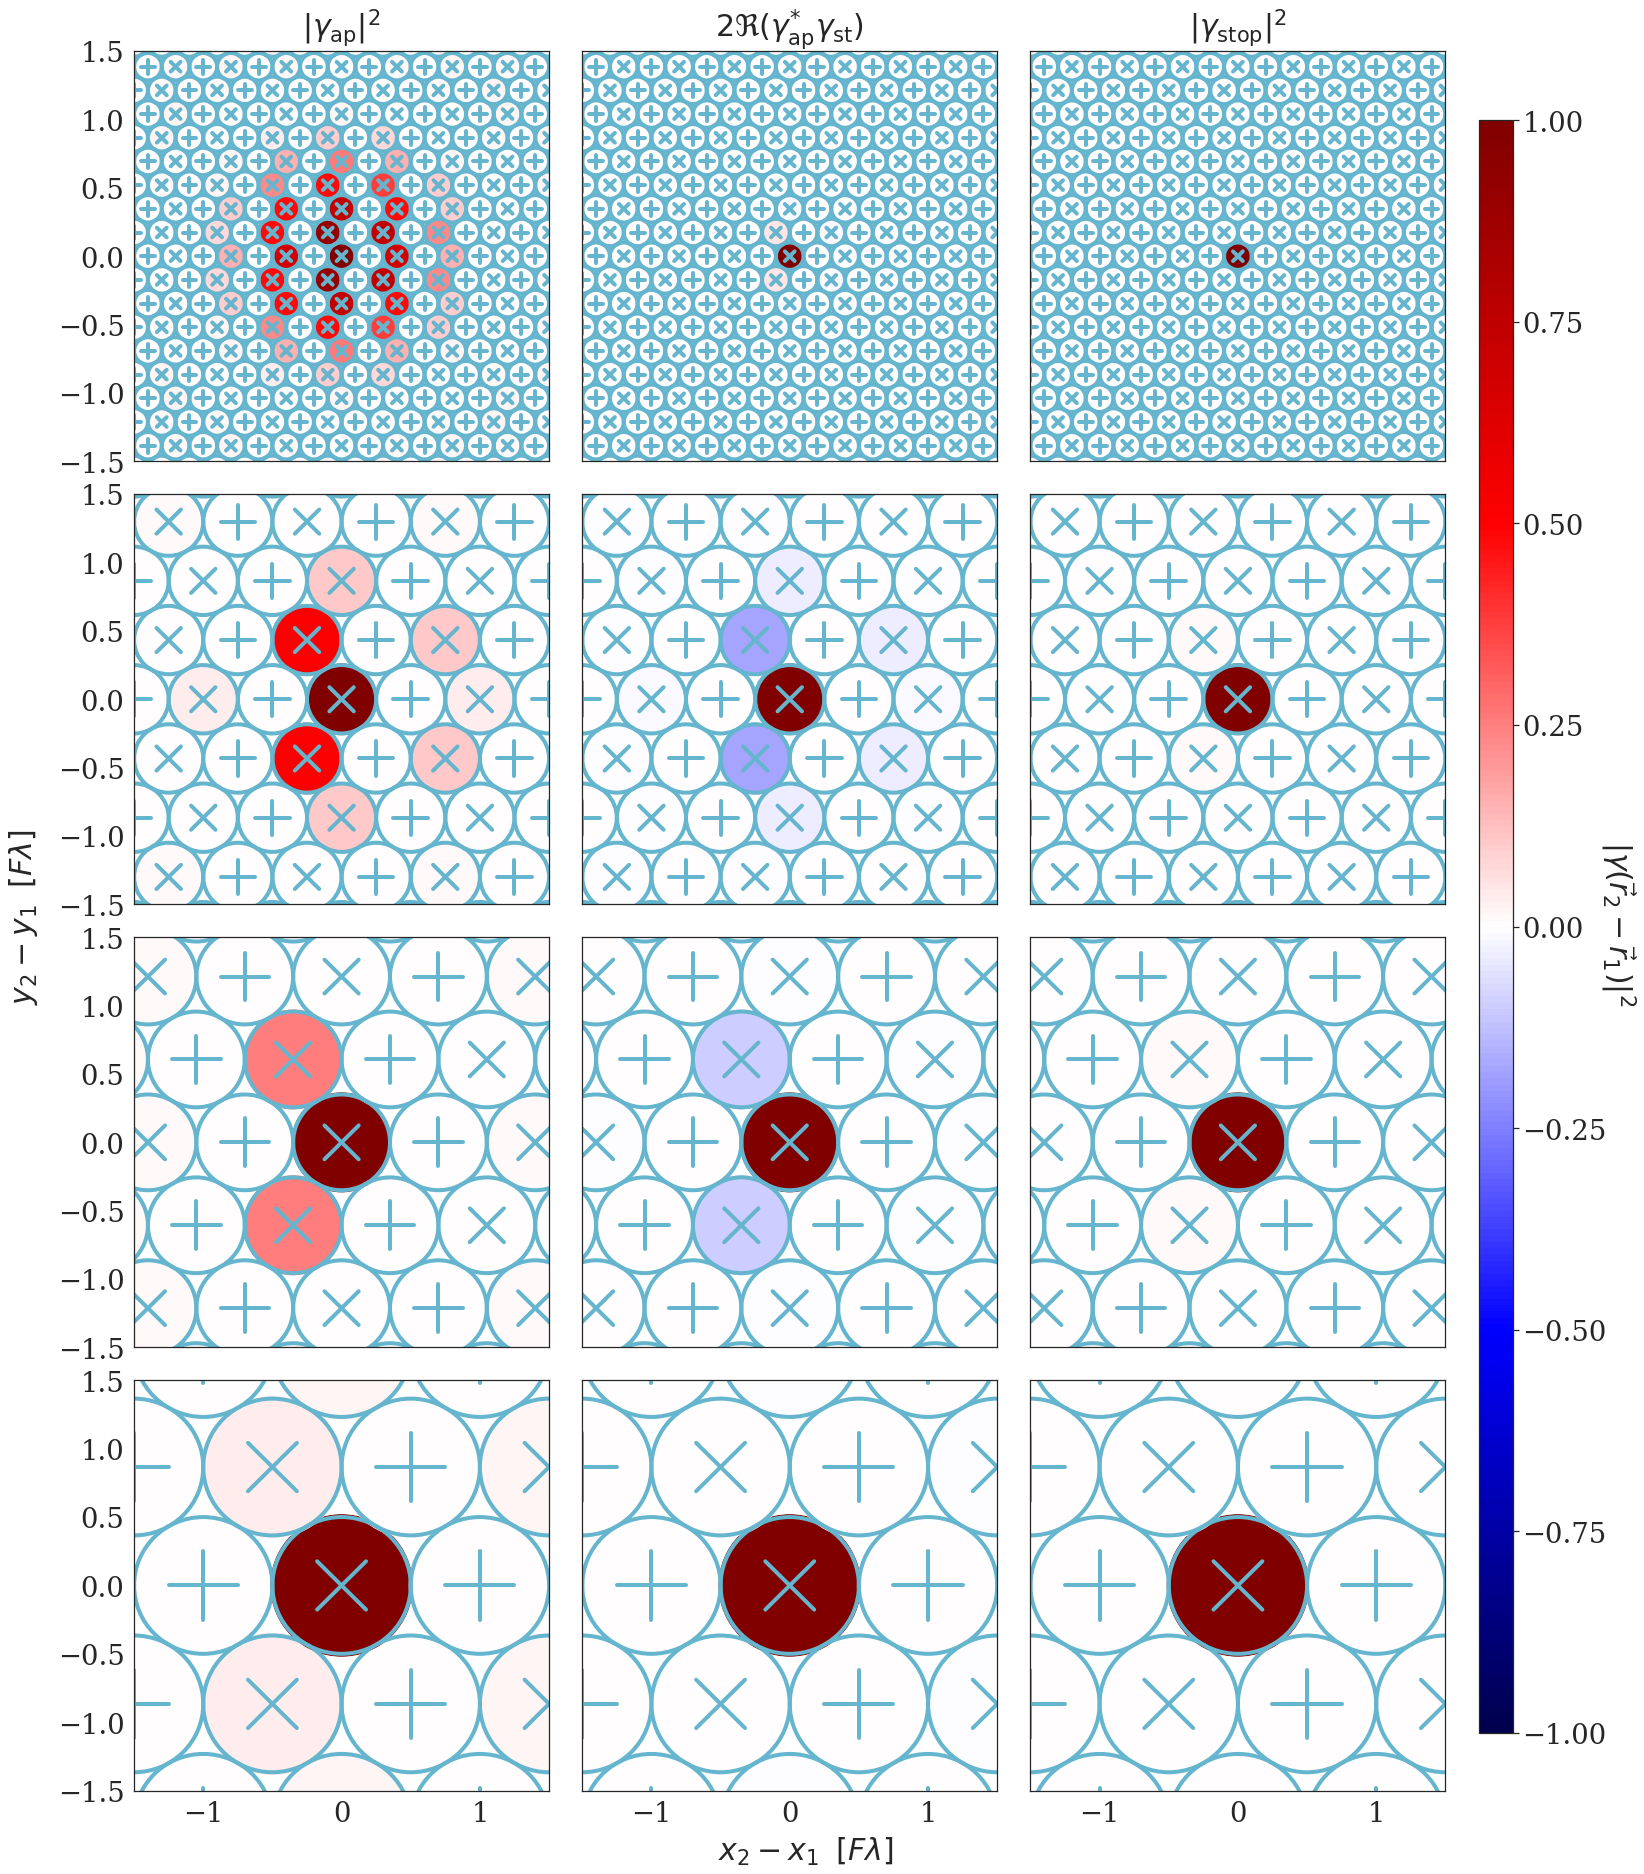

In [6]:
# Generate plot of correlation factor
sns.set(style='white', font_scale=2.5, font='serif')
fig, ax = plt.subplots(len(spacings), 3, sharex=True, sharey=True)
fig.set_figheight(8 * len(spacings))
fig.set_figwidth(23.5)
fig.subplots_adjust(hspace=0.08, wspace=0.08)

# Filler sizes
msize = 800
fsize = msize * (np.array(spacings)**2 / spacings[0]**2)

p_arr = []
lim = 1.5 * np.amax(spacing)
for i, spacing in enumerate(spacings):
    # Extract data
    Dpix = Dpix_arr[i]
    xplot = xplot_arr[i]
    yplot = yplot_arr[i]
    gplot_ap = abs(gplot_ap_arr[i])**2
    gplot_cr = 2 * np.real(np.conj(gplot_ap_arr[i]) * gplot_st_arr[i])
    gplot_st = abs(gplot_st_arr[i])**2
    
    # Plot pluses/crosses
    line_len = Dpix / 2
    plus_arr = np.linspace(-line_len / 2, line_len / 2, 5)
    cross_arr = plus_arr / np.sqrt(2)
    zero_arr = np.zeros(len(plus_arr))
    x0_arr = []
    xline_arr = []
    y0_arr = []
    yline_arr = []
    for ii, xy in enumerate(np.array(xy_arr[i]).T):
        x0, y0 = xy
        x0_arr.append(x0)
        y0_arr.append(y0)
        if ii % 2:
            xline_arr.append(
            [(x0) + cross_arr, (x0) + cross_arr])
            yline_arr.append(
            [(y0) + cross_arr, (y0) - cross_arr])
        else:
            xline_arr.append(
            [(x0) + plus_arr, (x0) + zero_arr])
            yline_arr.append(
            [(y0) + zero_arr, (y0) + plus_arr])

    # Plot for the aperture
    # Circle for each pixel
    circles = []
    for xy in np.array(xy_arr[i]).T:
        cir = plt.Circle(np.array(xy).T, (Dpix / 2), fill=False, color='c', linewidth=4, linestyle='-')
        circles.append(cir)
    for cir in circles:
        ax[i][0].add_artist(cir)
    # Contour plot
    p = ax[i][0].scatter(
        xplot, yplot, c=gplot_ap, marker='o', s=fsize[i], vmin=cbar_min, 
        vmax=cbar_max, 
        #norm=mpl.colors.SymLogNorm(linthresh, vmin=cbar_min, vmax=cbar_max), 
        cmap='seismic')
    p.set_clim(cbar_min, cbar_max)
    ax[i][0].set_xlim(-lim, lim)
    ax[i][0].set_ylim(-lim, lim)
    # Plot pluses and crosses
    for ii, xy in enumerate(np.array(xy_arr[i]).T):
        for jj in range(len(xline_arr[ii])):
            ax[i][0].plot(xline_arr[ii][jj], yline_arr[ii][jj], linewidth=4, color='c', linestyle='-')
    if i == 0:
        ax[i][0].set_title("$| \gamma_{\mathrm{ap}} |^{2}$", pad=15)
        
    # Plot for the cross correlation
    # Circle for each pixel
    circles = []
    for xy in np.array(xy_arr[i]).T:
        cir = plt.Circle(np.array(xy).T, (Dpix / 2), fill=False, color='c', linewidth=4, linestyle='-')
        circles.append(cir)
    for cir in circles:
        ax[i][1].add_artist(cir)
    # Contour plot
    p = ax[i][1].scatter(
        xplot, yplot, c=gplot_cr, marker='o', s=fsize[i], vmin=cbar_min, 
        vmax=cbar_max, 
        #norm=mpl.colors.SymLogNorm(linthresh, vmin=cbar_min, vmax=cbar_max), 
        cmap='seismic')
    p.set_clim(cbar_min, cbar_max)
    ax[i][1].set_xlim(-lim, lim)
    ax[i][1].set_ylim(-lim, lim)
    # Plot pluses and crosses
    for ii, xy in enumerate(np.array(xy_arr[i]).T):
        for jj in range(len(xline_arr[ii])):
            ax[i][1].plot(xline_arr[ii][jj], yline_arr[ii][jj], linewidth=4, color='c', linestyle='-')
    if i == 0:
        ax[i][1].set_title("$2 \Re(\gamma_{\mathrm{ap}}^{*} \gamma_{\mathrm{st}})$", pad=15)

    # Plot for the stop
    #Circle for each pixel
    circles = []
    for xy in np.array(xy_arr[i]).T:
        cir = plt.Circle(np.array(xy).T, (Dpix / 2), fill=False, color='c', linewidth=4, linestyle='-')
        circles.append(cir)
    for cir in circles:
        ax[i][2].add_artist(cir)
    # Contour plot
    p = ax[i][2].scatter(
        xplot, yplot, c=gplot_st, marker='o', s=fsize[i], vmin=cbar_min, 
        vmax=cbar_max, 
        #norm=mpl.colors.SymLogNorm(linthresh, vmin=cbar_min, vmax=cbar_max), 
        cmap='seismic')
    p.set_clim(cbar_min, cbar_max)
    ax[i][2].set_xlim(-lim, lim)
    ax[i][2].set_ylim(-lim, lim)
    # Plot pluses and crosses
    for ii, xy in enumerate(np.array(xy_arr[i]).T):
        for jj in range(len(xline_arr[ii])):
            ax[i][2].plot(xline_arr[ii][jj], yline_arr[ii][jj], linewidth=4, color='c', linestyle='-')
    if i == 0:
        ax[i][2].set_title("$| \gamma_{\mathrm{stop}} |^{2}$", pad=15)

fig.text(0.05, 0.47, r"$y_{2} - y_{1} \;\; [F \lambda]$", rotation=90)
fig.text(0.47, 0.095, r"$x_{2} - x_{1} \;\; [F \lambda]$")
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
plt.colorbar(p, cax=cbar_ax)
fig.text(0.99, 0.47, r"$\left| \gamma(\vec{r}_{2} - \vec{r}_{1}) \right|^{2}$", rotation=270)
plt.savefig(os.path.join("Plots", "pixel_spacing_contour_plot.pdf"), bbox_inches='tight')
sns.set(style='whitegrid', font_scale=2.5, font='serif')

# Simulate mapping speed

In [8]:
# Band center frequencies
names = np.array([35, 95, 150, 220])
freqs = names * GHz
# Fractional band widths
fbws = [0.50, 0.35, 0.263, 0.20]
# Plotting styles
colors = ['b', 'r', 'g', 'c']
linestyles = ['-', '--', ':', '-.']

# Define the sky
site = 'Atacama'
pwv = 1.0 * 1e3  # um
elev = 50  # deg
atm_freq, atm_tran, atm_temp = np.loadtxt(
    os.path.join("Data", "%s_%dum_%ddeg.txt" % (site, pwv, elev)), unpack=True, usecols=[0, 1, 2])

# Telescope temperature
Ttel = 10 # K
# Stop temperature
Tstop = 4 # K
# Detector quantum efficiency
det_eff = 0.8

# Pixel spacings to calculate
spacings = np.linspace(0.05, 4.0, 100) # F-lambda

## Plot source temperatures

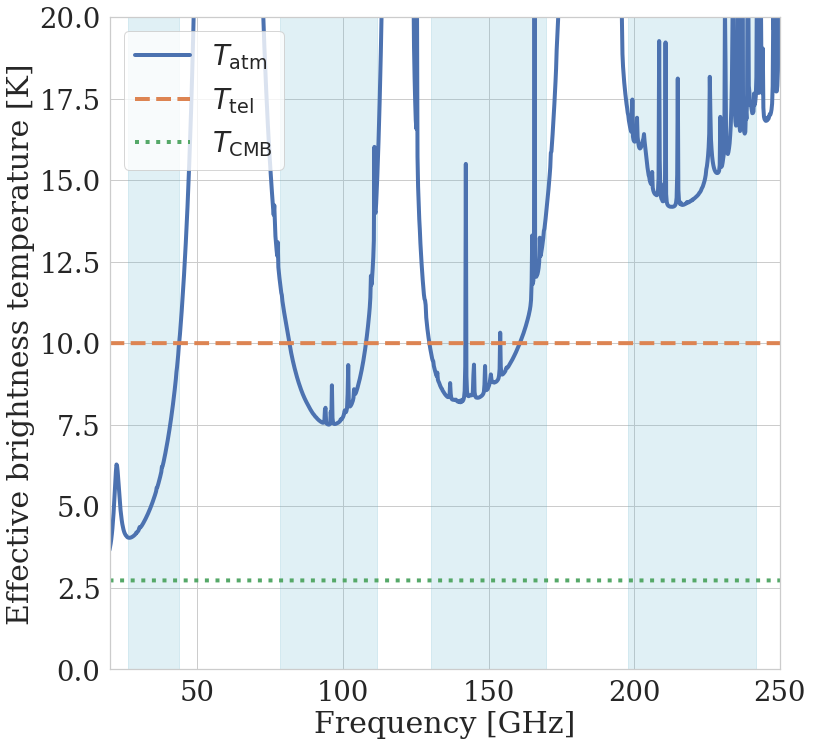

In [9]:
# Plot the various loading contributions
plt.figure(figsize=(12,12))
plt.plot(atm_freq, det_eff * 0.95 * atm_temp, linewidth=4, linestyle='-', label=r"$T_{\mathrm{atm}}$")
plt.plot(atm_freq, [Ttel] * len(atm_freq), linewidth=4, linestyle='--', label=r"$T_{\mathrm{tel}}$")
plt.plot(atm_freq, [Tcmb] * len(atm_freq), linewidth=4, linestyle=':', label=r"$T_{\mathrm{CMB}}$")
for i, freq in enumerate(freqs):
    freq = freq * 1e-9
    flo, fhi = band(freq, fbws[i])
    plt.axvspan(flo, fhi, color='c', alpha=0.2)
plt.xlabel("Frequency [GHz]")
plt.ylabel("Effective brightness temperature [K]")
plt.xlim(20, 250)
plt.ylim(0, 20)
plt.legend(loc='upper left')
plt.savefig(os.path.join("Plots", "source_temperatures.pdf"), bbox_layout='tight')

## Plot bose fraction

In [10]:
# Source temperatures
sky_T = np.linspace(0, 50, 100)
tel_T = 1e-6
cmb_T = 1e-6

In [11]:
# First calculate the correlation coefficient
bose_frac_arr = []
for i, freq in enumerate(freqs):
    fbw = fbws[i]
    lamb = c / freq
    Dpix = 3 # F-lambda
    # Calculate bose fraction for many sky temperatures
    bose_frac_arr_arr = []
    for Tsk in sky_T:
        Ts = [Tsk] * len(atm_freq)
        nep2_shot, nep2_bose = MS_det(
            freq, fbw, Dpix, F_num, w_f,
            0, 0,
            atm_freq * GHz, Ts, atm_tran, cmb_T, tel_T, Tstop, det_eff)[1:3]
        bose_frac_arr_arr.append((nep2_bose / (nep2_shot + nep2_bose)))
    bose_frac_arr.append(bose_frac_arr_arr)

/Users/chill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in true_divide


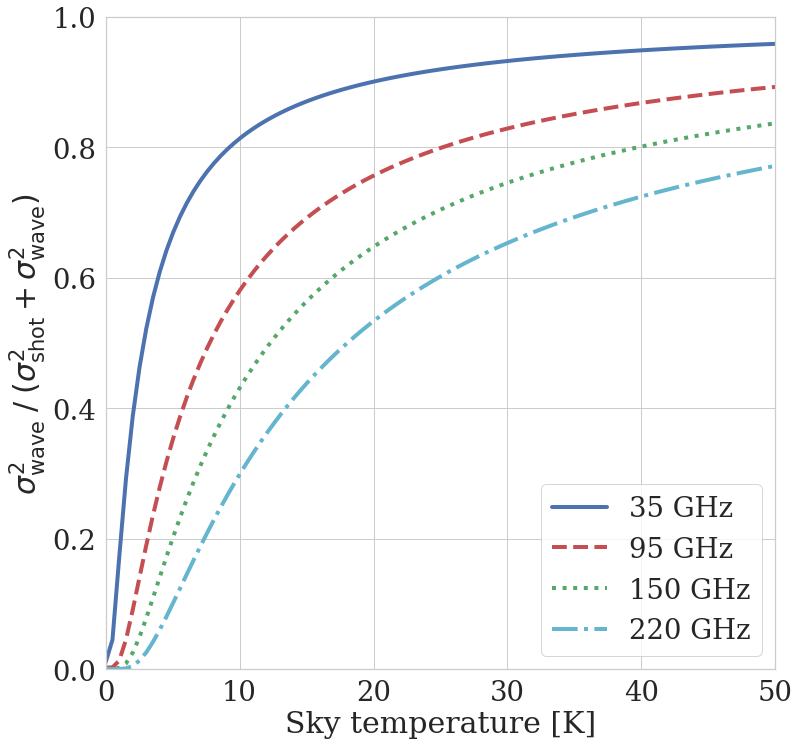

In [12]:
plt.figure(figsize=(12,12))
for i, freq in enumerate(freqs):
    plt.plot(sky_T, bose_frac_arr[i], label="%d GHz" % (names[i]),
             linewidth=4, linestyle=linestyles[i], color=colors[i])
plt.xlabel("Sky temperature [K]")
plt.ylabel(r"$\sigma_{\mathrm{wave}}^{2} \; / \; (\sigma_{\mathrm{shot}}^{2} + \sigma_{\mathrm{wave}}^{2})$")
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.legend()
plt.savefig(os.path.join("Plots", "bose_factor.pdf"), bbox_layout='tight')

## Example "classic" mapping speed

In [13]:
ind = 1  # 95 GHz
freq = freqs[ind]
fbw = fbws[ind]
nepg2_frac = 0.1

In [14]:
# Calculate sensitivity for each spacing scenario
MS_arr = []
ap_eff_arr = []
ndet_arr = []
for j, spacing in enumerate(spacings):
    MS = MS_det(
        freq, fbw, spacing, F_num, w_f,
        1, 1,
        atm_freq * GHz, atm_temp, atm_tran, Tcmb, Ttel, Tstop, det_eff, nepg2_frac=nepg2_frac)[4]
    ap_eff = beam_coupling_eff(spacing, w_f)
    ap_eff_arr.append(ap_eff)
    ndet = (1 / spacing)**2
    ndet_arr.append(ndet)
    MS_arr.append(MS)
MS_tot = np.array([MS_arr[j] * (1 / spacings[j])**2 for j in range(len(spacings))])

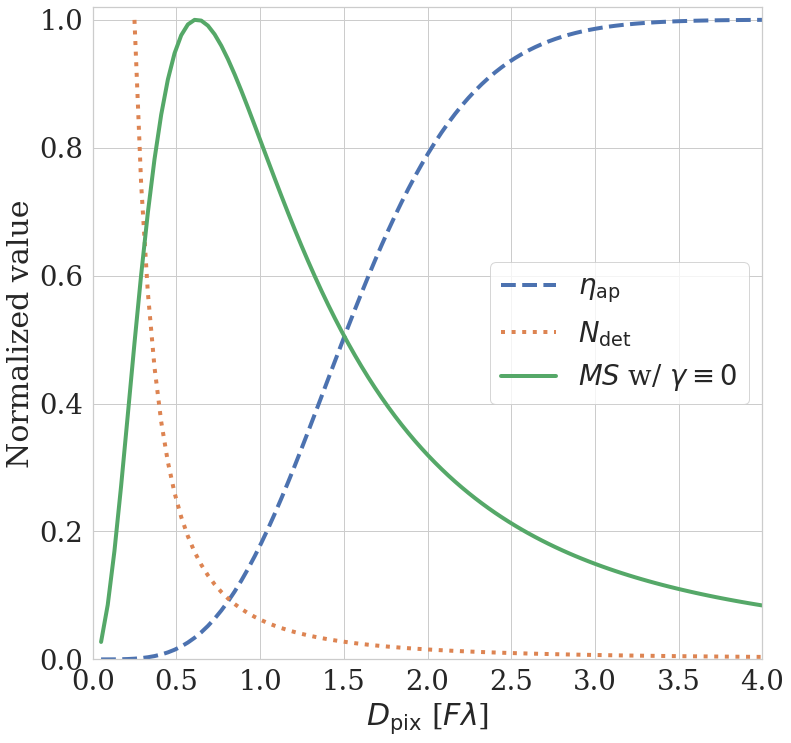

In [15]:
# Plot the mapping speed explanation
ap_eff_plot = (np.array(ap_eff_arr) / np.amax(ap_eff_arr))**2
ndet_plot = np.array(ndet_arr[5:]) / np.amax(ndet_arr[5:])
ms_plot = MS_tot / np.amax(MS_tot)
plt.figure(figsize=(12,12))
plt.plot(spacings, ap_eff_plot, linewidth=4, label="$\eta_{\mathrm{ap}}$", linestyle='--')
plt.plot(spacings[5:], ndet_plot, linewidth=4, label="$N_{\mathrm{det}}$", linestyle=':')
plt.plot(spacings, ms_plot, linewidth=4, label="$MS$ w/ $\gamma \equiv 0$", linestyle='-')
plt.xlabel("$D_{\mathrm{pix}}$ [$F \lambda$]")
plt.ylabel("Normalized value")
plt.xlim(0, 4)
plt.ylim(0, 1.02)
plt.legend()
plt.savefig(os.path.join("Plots", "mapping_speed_demo.pdf"))

## Correlated mapping speed w/ NEPg^2 = 0.1 * NEPph^2

### Calculate correlation coefficients

In [16]:
Dpix_arr = []
gamma_arr = []
# Calculate the correlation coefficient for each spacing scenario
for spacing in spacings:
    # Get a hex packed grid of pixels
    Dpix_arr.append(spacing)
    x, y = hex_pack(spacing)
    # Get the correlation coefficients
    gammas_ap, gammas_st = vczt_coeffs(x, y, spacing, F_num, D_ap, w_f)
    gamma_arr.append([gammas_ap, gammas_st])

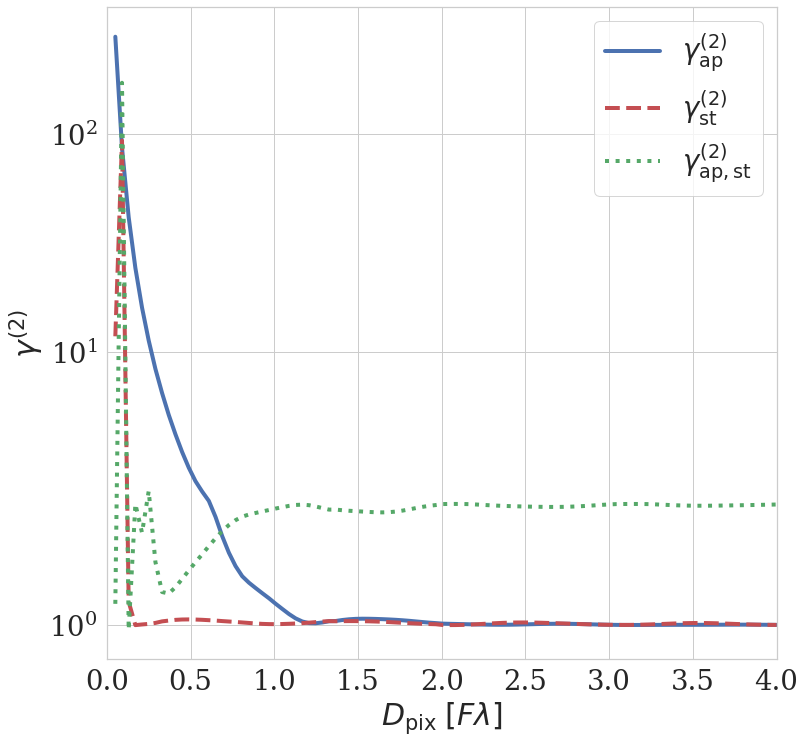

In [17]:
plt.figure(figsize=(12, 12))

plt.plot(spacings, [np.sum(np.abs(gamma_arr[i][0])**2) for i in range(len(spacings))], 
         color=colors[0], linestyle=linestyles[0], linewidth=4, label=r"$\gamma_{\mathrm{ap}}^{(2)}$")
plt.plot(spacings, [np.sum(np.abs(gamma_arr[i][1])**2) for i in range(len(spacings))], 
         color=colors[1], linestyle=linestyles[1], linewidth=4, label=r"$\gamma_{\mathrm{st}}^{(2)}$")
plt.plot(spacings, [2 * np.sum(np.conj(gamma_arr[i][0]) * np.array(gamma_arr[i][1])) for i in range(len(spacings))], 
         color=colors[2], linestyle=linestyles[2], linewidth=4, label=r"$\gamma_{\mathrm{ap,st}}^{(2)}$")
plt.legend()
plt.xlim(0, 4)
plt.xlabel("$D_{\mathrm{pix}} \; [F \lambda]$")
plt.ylabel(r"$\gamma^{(2)}$")
plt.yscale('symlog')
plt.savefig(os.path.join("Plots", "MISC", "gamma2_sum.pdf"), bbox_inches='tight')

### CMB only

In [18]:
sky_T = [1e-6] * len(atm_freq)
sky_eff = [1.0] * len(atm_freq)
tel_T = 1e-6
cmb_T = Tcmb
nepg2_frac = 0.1

In [19]:
MS_arr = []
# Loop over frequency bands
for i, freq in enumerate(freqs):
    fbw = fbws[i]
    MS_arr_arr = []
    # Calculate sensitivity for each spacing scenario
    for j, spacing in enumerate(spacings):
        MS_corr, MS = MS_det(
            freq, fbw, spacing, F_num, w_f,
            np.array(gamma_arr[j][0]), np.array(gamma_arr[j][1]),
            atm_freq * GHz, sky_T, sky_eff, cmb_T, tel_T, Tstop, det_eff, nepg2_frac=nepg2_frac)[3:]
        MS_arr_arr.append(np.array([MS_corr, MS]))
    MS_tot = np.array([MS_arr_arr[j] * (1 / spacings[j])**2 for j in range(len(spacings))])
    MS_tot = MS_tot / np.amax(MS_tot)
    MS_arr.append(MS_tot)
MS_cmb = MS_arr

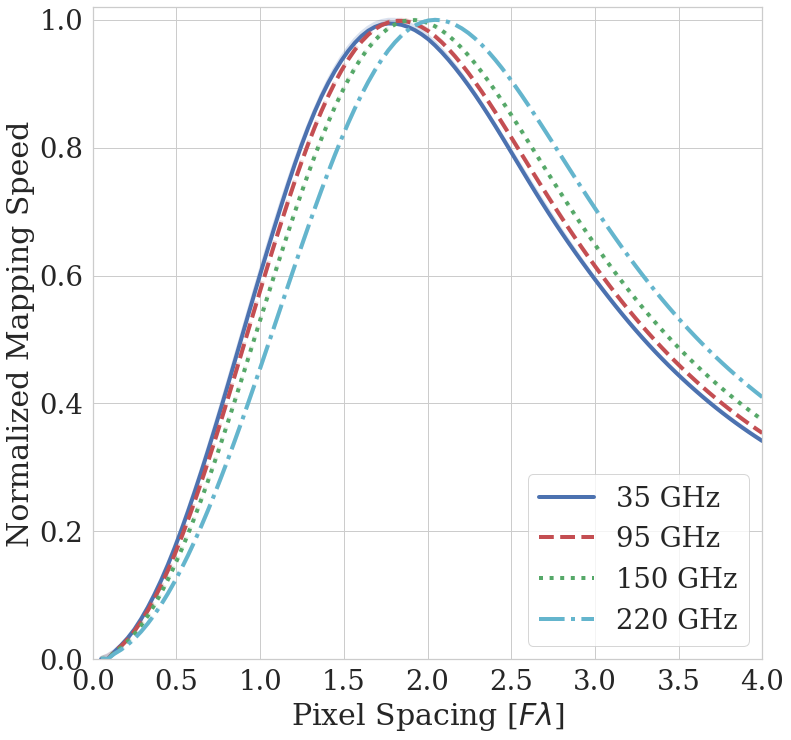

In [20]:
plt.figure(figsize=(12,12))
MS_plot = np.transpose(MS_arr, (0, 2, 1))
for i in range(len(MS_arr)):
    plt.plot(spacings, MS_plot[i][0], linewidth=4, label='%d GHz' % (names[i]),
             color=colors[i], linestyle=linestyles[i])
    plt.plot(spacings, MS_plot[i][1], linewidth=4, 
             color=colors[i], linestyle=linestyles[i], alpha=0.2)
plt.ylabel("Normalized Mapping Speed")
plt.xlabel("Pixel Spacing [$F \lambda$]")
plt.legend()
plt.xlim(0, 4)
plt.ylim(0, 1.02)
plt.savefig(os.path.join("Plots", "MISC", "mapping_speed_corr_cmb.pdf"))

### Atmosphere only

In [21]:
sky_T = atm_temp
sky_eff = atm_tran
tel_T = 1e-6
cmb_T = 1e-6

In [22]:
MS_arr = []
# Loop over frequency bands
for i, freq in enumerate(freqs):
    fbw = fbws[i]
    MS_arr_arr = []
    # Calculate sensitivity for each spacing scenario
    for j, spacing in enumerate(spacings):
        MS_corr, MS = MS_det(
            freq, fbw, spacing, F_num, w_f,
            np.array(gamma_arr[j][0]), np.array(gamma_arr[j][1]),
            atm_freq * GHz, sky_T, sky_eff, cmb_T, tel_T, Tstop, det_eff, nepg2_frac=nepg2_frac)[3:]
        MS_arr_arr.append(np.array([MS_corr, MS]))
    MS_tot = np.array([MS_arr_arr[j] * (1 / spacings[j])**2 for j in range(len(spacings))])
    MS_tot = MS_tot / np.amax(MS_tot)
    MS_arr.append(MS_tot)
MS_atm = MS_arr

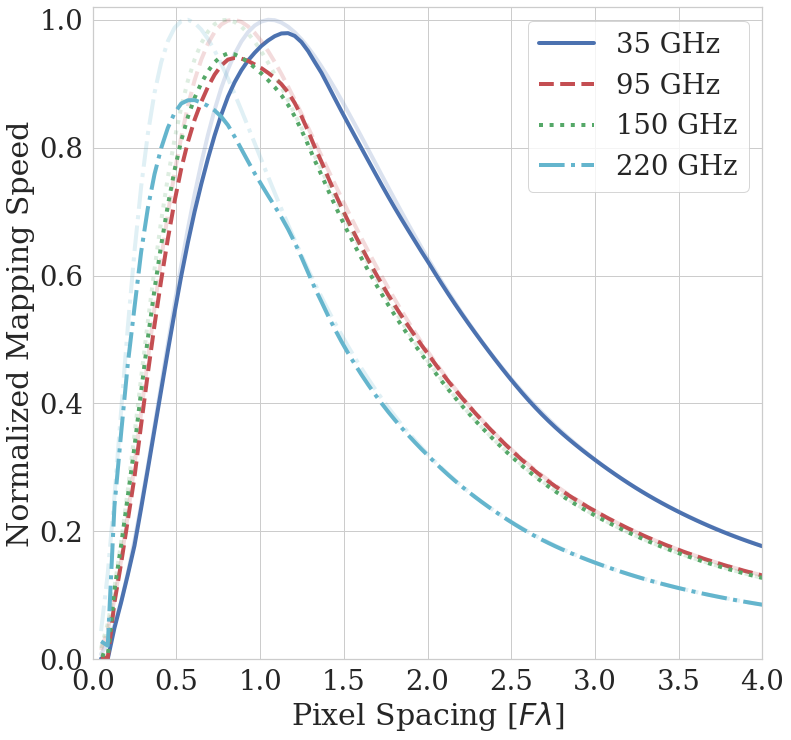

In [23]:
plt.figure(figsize=(12,12))
MS_plot = np.transpose(MS_arr, (0, 2, 1))
for i in range(len(MS_arr)):
    plt.plot(spacings, MS_plot[i][0], linewidth=4, label='%d GHz' % (names[i]),
             color=colors[i], linestyle=linestyles[i])
    plt.plot(spacings, MS_plot[i][1], linewidth=4, 
             color=colors[i], linestyle=linestyles[i], alpha=0.2)
plt.ylabel("Normalized Mapping Speed")
plt.xlabel("Pixel Spacing [$F \lambda$]")
plt.legend()
plt.xlim(0, 4)
plt.ylim(0, 1.02)
plt.savefig(os.path.join("Plots", "MISC", "mapping_speed_corr_atm.pdf"))

### Telescope only

In [24]:
sky_T = [1.e-6] * len(atm_freq)
sky_eff = atm_tran
tel_T = Ttel
cmb_T = 1e-6
nepg2_frac = 0.1

In [25]:
MS_arr = []
# Loop over frequency bands
for i, freq in enumerate(freqs):
    fbw = fbws[i]
    MS_arr_arr = []
    # Calculate sensitivity for each spacing scenario
    for j, spacing in enumerate(spacings):
        MS_corr, MS = MS_det(
            freq, fbw, spacing, F_num, w_f,
            np.array(gamma_arr[j][0]), np.array(gamma_arr[j][1]),
            atm_freq * GHz, sky_T, sky_eff, cmb_T, tel_T, Tstop, det_eff, nepg2_frac=nepg2_frac)[3:]
        MS_arr_arr.append(np.array([MS_corr, MS]))
    MS_tot = np.array([MS_arr_arr[j] * (1 / spacings[j])**2 for j in range(len(spacings))])
    MS_tot = MS_tot / np.amax(MS_tot)
    MS_arr.append(MS_tot)
MS_tel = MS_arr

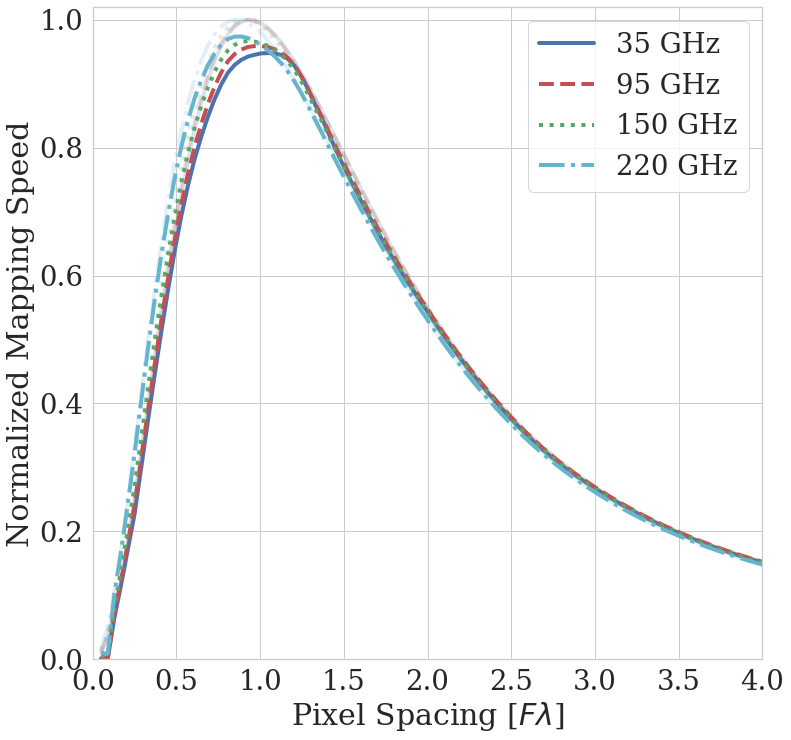

In [26]:
plt.figure(figsize=(12,12))
MS_plot = np.transpose(MS_arr, (0, 2, 1))
for i in range(len(MS_arr)):
    plt.plot(spacings, MS_plot[i][0], linewidth=4, label='%d GHz' % (names[i]),
             color=colors[i], linestyle=linestyles[i])
    plt.plot(spacings, MS_plot[i][1], linewidth=4, 
             color=colors[i], linestyle=linestyles[i], alpha=0.2)
plt.ylabel("Normalized Mapping Speed")
plt.xlabel("Pixel Spacing [$F \lambda$]")
plt.legend()
plt.xlim(0, 4)
plt.ylim(0, 1.02)
plt.savefig(os.path.join("Plots", "MISC", "mapping_speed_corr_tel.pdf"))

### CMB + Atmosphere + Telescope

In [27]:
sky_T = atm_temp
sky_eff = atm_tran
tel_T = Ttel
cmb_T = Tcmb
nepg2_frac = 0.1

In [28]:
MS_arr = []
# Loop over frequency bands
for i, freq in enumerate(freqs):
    fbw = fbws[i]
    MS_arr_arr = []
    # Calculate sensitivity for each spacing scenario
    for j, spacing in enumerate(spacings):
        MS_corr, MS = MS_det(
            freq, fbw, spacing, F_num, w_f,
            np.array(gamma_arr[j][0]), np.array(gamma_arr[j][1]),
            atm_freq * GHz, sky_T, sky_eff, cmb_T, tel_T, Tstop, det_eff, nepg2_frac=nepg2_frac)[3:]
        MS_arr_arr.append(np.array([MS_corr, MS]))
    MS_tot = np.array([MS_arr_arr[j] * (1 / spacings[j])**2 for j in range(len(spacings))])
    MS_tot = MS_tot / np.amax(MS_tot)
    MS_arr.append(MS_tot)
MS_all = MS_arr

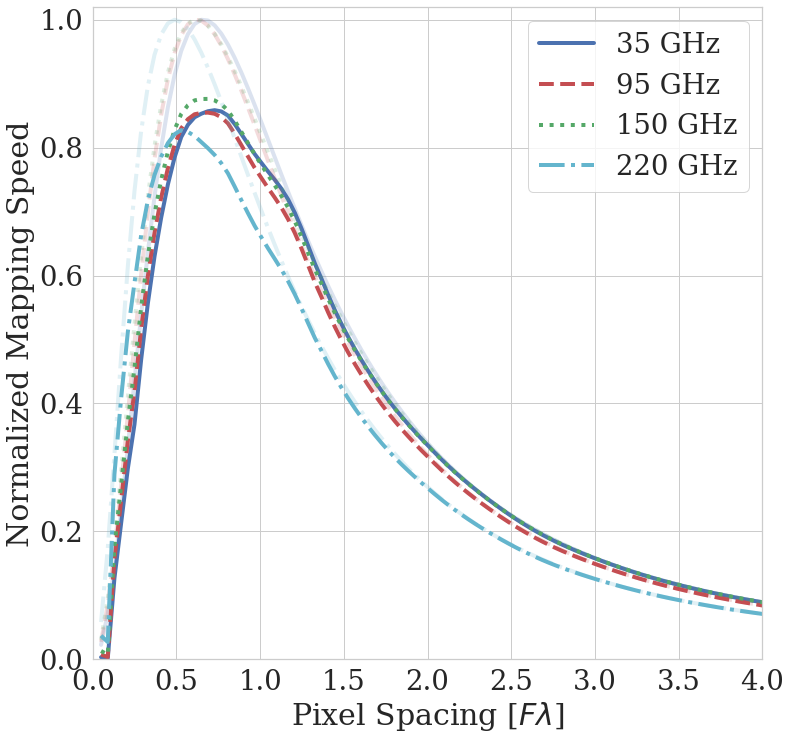

In [29]:
plt.figure(figsize=(12,12))
MS_plot = np.transpose(MS_arr, (0, 2, 1))
for i in range(len(MS_arr)):
    plt.plot(spacings, MS_plot[i][0], linewidth=4, label='%d GHz' % (names[i]),
             color=colors[i], linestyle=linestyles[i])
    plt.plot(spacings, MS_plot[i][1], linewidth=4, 
             color=colors[i], linestyle=linestyles[i], alpha=0.2)
plt.ylabel("Normalized Mapping Speed")
plt.xlabel("Pixel Spacing [$F \lambda$]")
plt.legend()
plt.xlim(0, 4)
plt.ylim(0, 1.02)
plt.savefig(os.path.join("Plots", "MISC", "mapping_speed_corr_all.pdf"))

### Combined plot

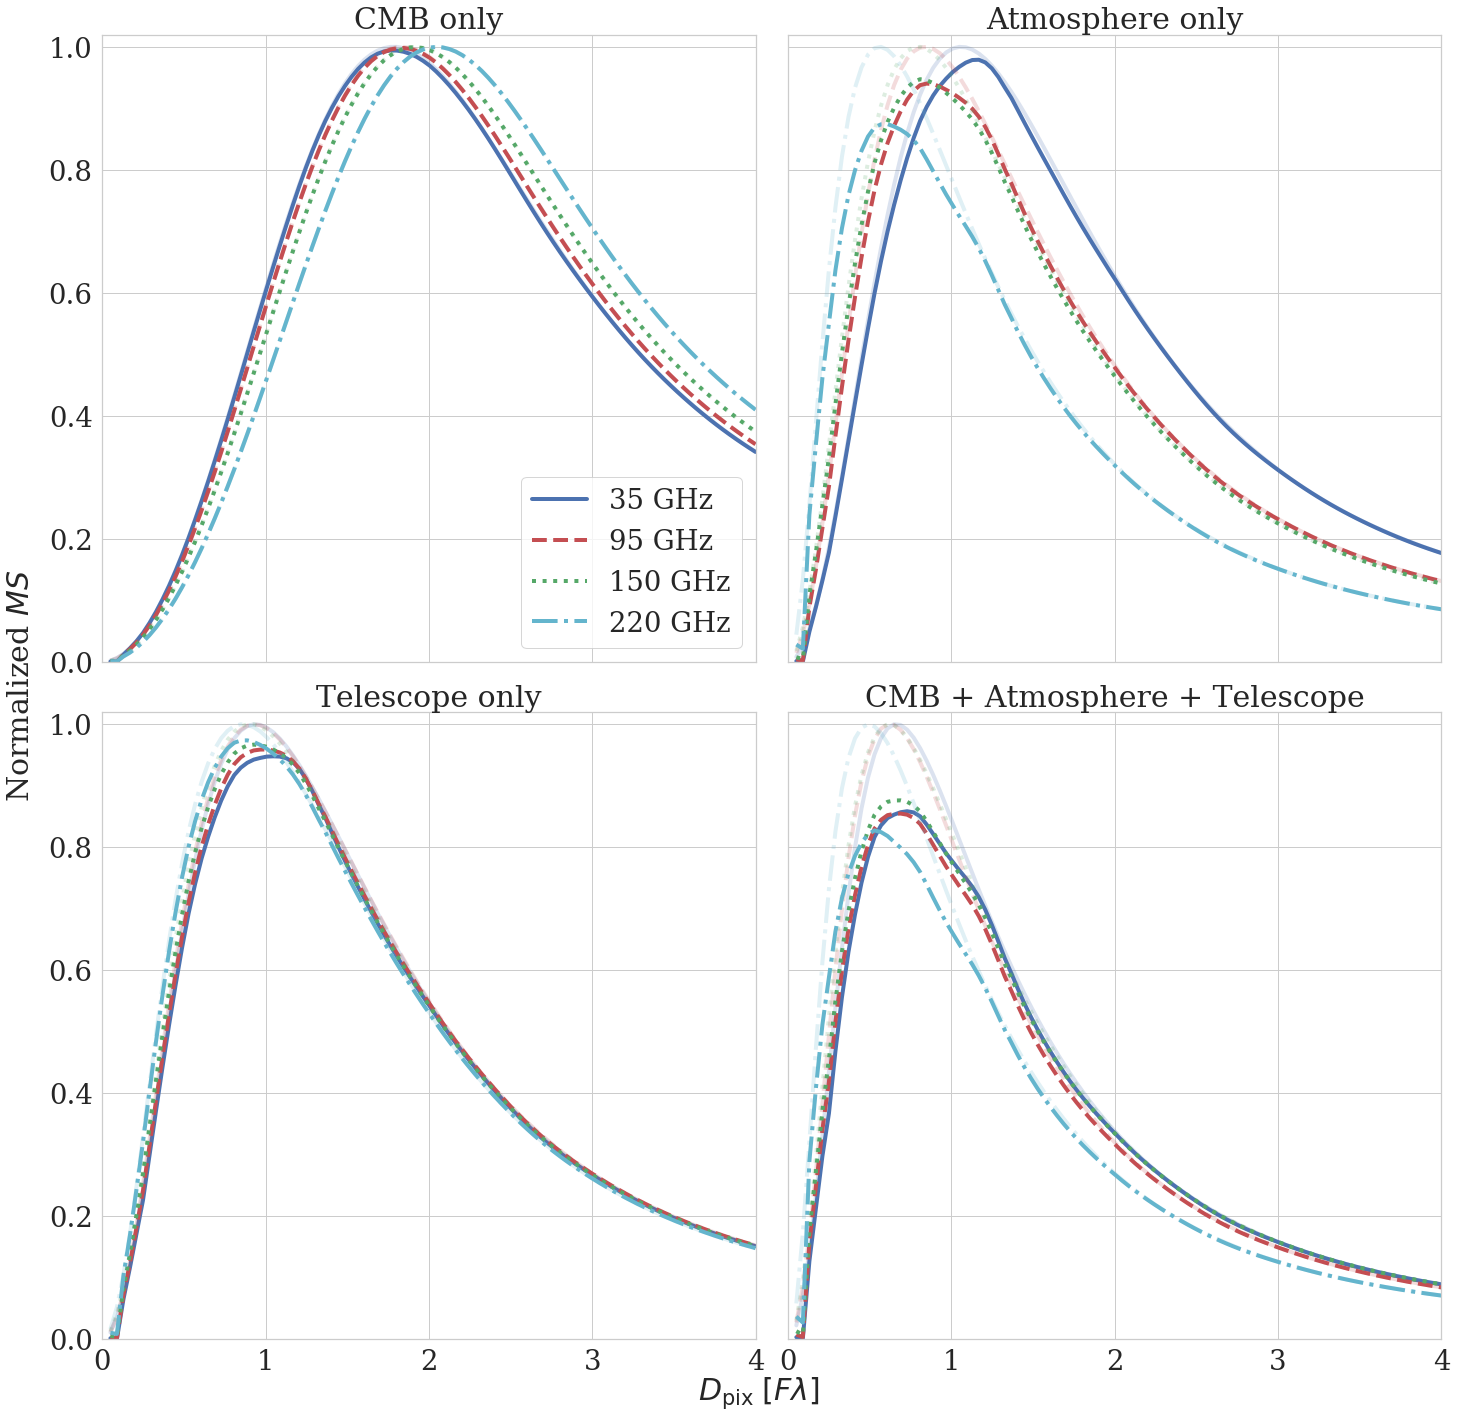

In [30]:
data = np.transpose(np.array([MS_cmb, MS_atm, MS_tel, MS_all]), (0, 1, 3, 2))

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(wspace=wspace, hspace=hspace)
fig.set_figheight(24)
fig.set_figwidth(24)
lab_arr = ['%d GHz' % (name) for name in names]
title_arr = ['CMB only', 'Atmosphere only', 'Telescope only', 'CMB + Atmosphere + Telescope']

for i, dat in enumerate(data):
    MS_plot = dat
    ind1 = i // 2
    ind2 = i % 2
    for j in range(len(dat)):
        ax[ind1][ind2].plot(spacings, MS_plot[j][0], linewidth=4, label='%s' % (lab_arr[j]),
                            color=colors[j], linestyle=linestyles[j])
        ax[ind1][ind2].plot(spacings, MS_plot[j][1], linewidth=4, 
                           color=colors[j], linestyle=linestyles[j], alpha=0.2)
    if i == 0:
        ax[ind1][ind2].legend()
    ax[ind1][ind2].set_ylim(0.0, 1.02)
    ax[ind1][ind2].set_xlim(0, 4)
    ax[ind1][ind2].set_title("%s" % (title_arr[i]))
fig.text(0.07, 0.44, "Normalized $MS$", rotation=90)
fig.text(0.47, 0.09, "$D_{\mathrm{pix}} \; [F \lambda]$")
plt.savefig(os.path.join("Plots", "mapping_speed_quad.pdf"), bbox_inches='tight')

## Impact of stop temperature

In [31]:
sky_T = atm_temp
sky_eff = atm_tran
tel_T_arr = Ttel
cmb_T = Tcmb
stop_T_arr = [2, 3, 4, 5]
nepg2_frac = 0.1

In [32]:
MS_arr = []
for a, stop_T in enumerate(stop_T_arr):
    MS_arr_arr = []
    for i, freq in enumerate(freqs):
        fbw = fbws[i]
        MS_arr_arr_arr = []
        # Calculate sensitivity for each spacing scenario
        for j, spacing in enumerate(spacings):
            MS_corr, MS = MS_det(
                freq, fbw, spacing, F_num, w_f,
                np.array(gamma_arr[j][0]), np.array(gamma_arr[j][1]),
                atm_freq * GHz, sky_T, sky_eff, cmb_T, tel_T, stop_T, det_eff, nepg2_frac=nepg2_frac)[3:]
            MS_arr_arr_arr.append(np.array([MS_corr, MS]))
        MS_tot = np.array([MS_arr_arr_arr[j] * (1 / spacings[j])**2 for j in range(len(spacings))])
        MS_tot = MS_tot / np.amax(MS_tot)
        MS_arr_arr.append(MS_tot)
    MS_arr.append(MS_arr_arr)

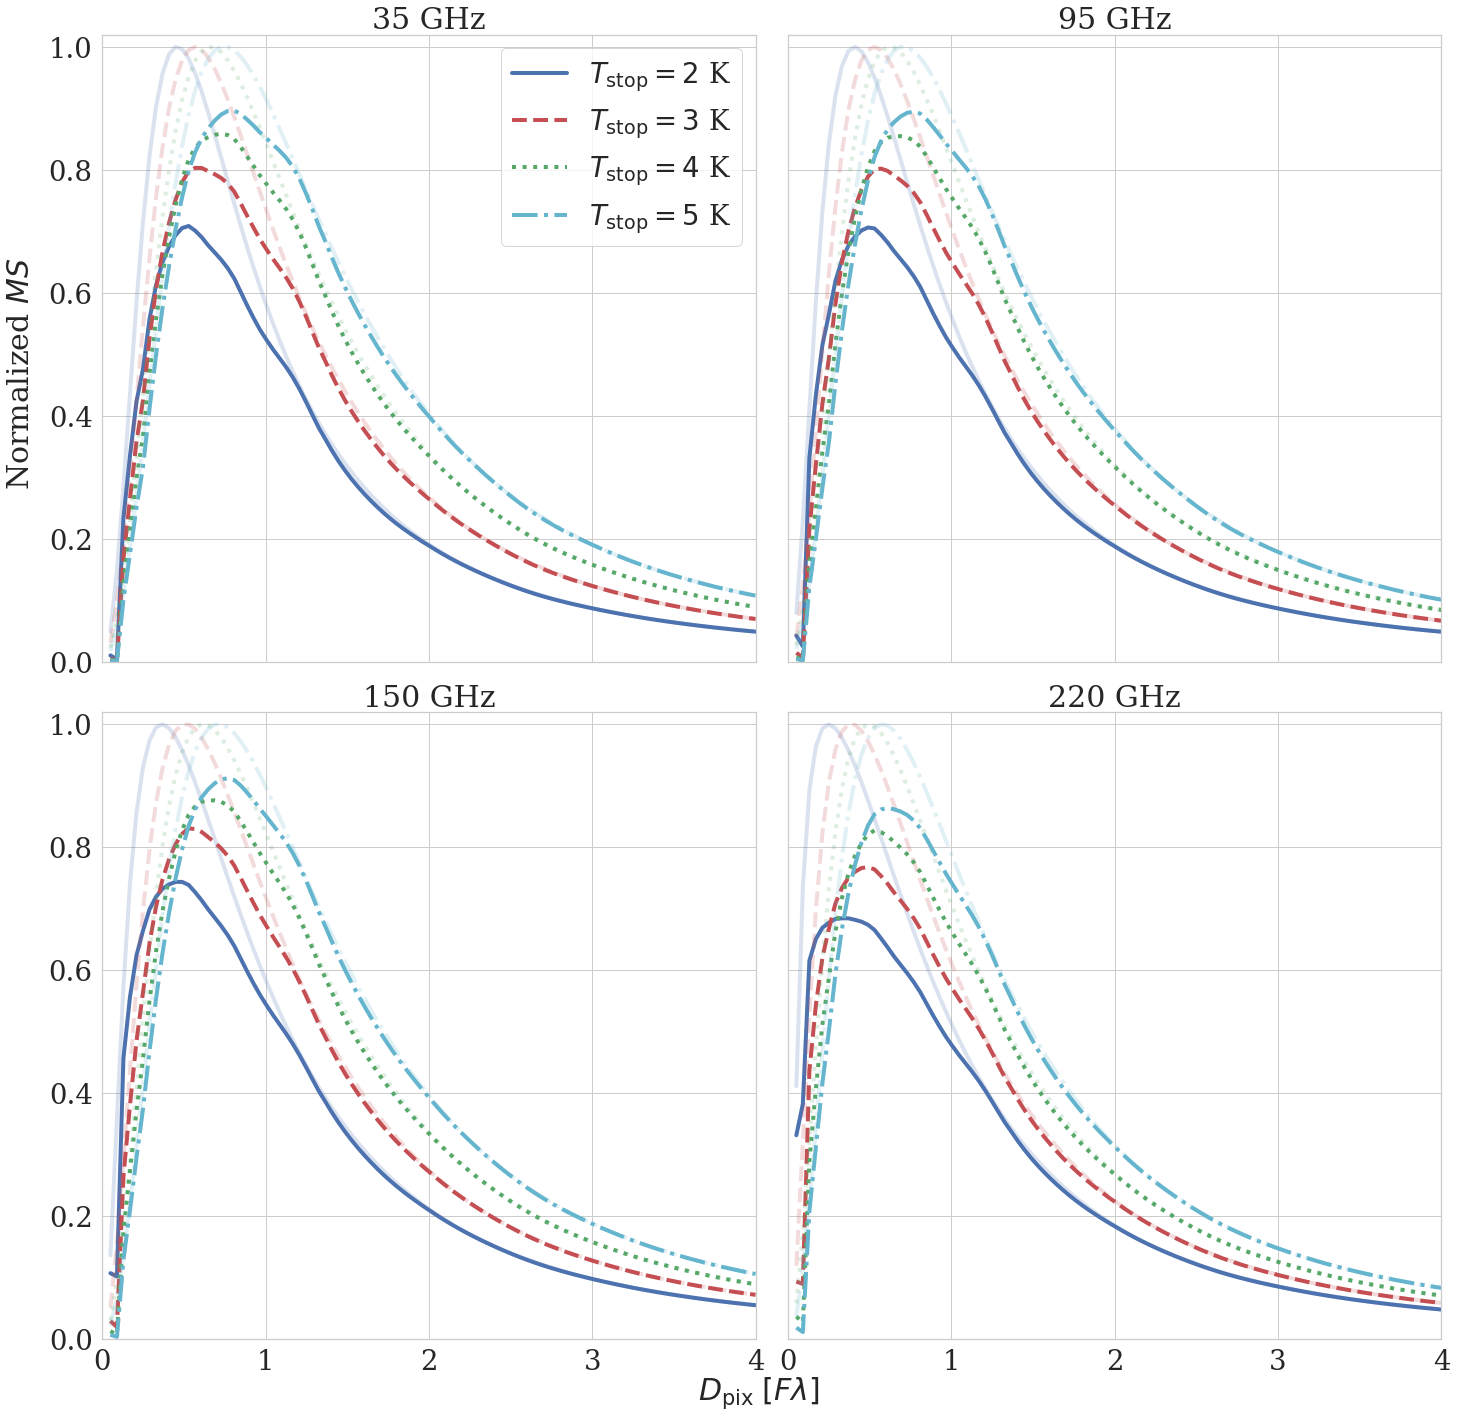

In [33]:
stop_data = np.transpose(MS_arr, (1, 0, 3, 2))

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(wspace=wspace, hspace=hspace)
fig.set_figheight(24)
fig.set_figwidth(24)

for i, dat in enumerate(stop_data):
    MS_plot = dat
    ind1 = i // 2
    ind2 = i % 2
    for j, stop_T in enumerate(stop_T_arr):
        ax[ind1][ind2].plot(spacings, MS_plot[j][0], linewidth=4,
                            label=r'$T_{\mathrm{stop}} = %d$ K' % (stop_T),
                            color=colors[j], linestyle=linestyles[j])
        ax[ind1][ind2].plot(spacings, MS_plot[j][1], linewidth=4, 
                           color=colors[j], linestyle=linestyles[j], alpha=0.2)
    if i == 0:
        ax[ind1][ind2].legend()
    ax[ind1][ind2].set_ylim(0.0, 1.02)
    ax[ind1][ind2].set_xlim(0, 4)
    ax[ind1][ind2].set_title("%d GHz" % (names[i]))
fig.text(0.07, 0.62, "Normalized $MS$", rotation=90)
fig.text(0.47, 0.09, "$D_{\mathrm{pix}} \; [F \lambda]$")
plt.savefig(os.path.join("Plots", "MISC", "mapping_speed_stopT_quad.pdf"), bbox_inches='tight')

## Impact of NEPg

In [34]:
sky_T = atm_temp
sky_eff = atm_tran
tel_T = Ttel
cmb_T = Tcmb
nepg2_frac_arr = np.array([0.1, 0.3, 0.5, 1.0])

In [35]:
# Calculate NEPph at 2 F \lambda, and force NEPg to be a fraction of that
NEPg2_arr = []
for a, nepg2_frac in enumerate(nepg2_frac_arr):
    NEPg2_arr_arr = []
    for i, freq in enumerate(freqs):
        lamb = c / freq
        fbw = fbws[i]
        spacing = 1.2 # F-lambda
        NEPph2_shot, NEPph2_wave = MS_det(
            freq, fbw, spacing, F_num, w_f, 
            0, 0,
            atm_freq * GHz, sky_T, sky_eff, cmb_T, tel_T, Tstop, det_eff)[1:3]
        NEPph2 = NEPph2_shot + NEPph2_wave
        NEPg2 = nepg2_frac * NEPph2
        NEPg2_arr_arr.append(NEPg2)
    NEPg2_arr.append(NEPg2_arr_arr)

In [36]:
MS_arr = []
for a, nepg2 in enumerate(NEPg2_arr):
    MS_arr_arr = []
    for i, freq in enumerate(freqs):
        fbw = fbws[i]
        MS_arr_arr_arr = []
        # Calculate sensitivity for each spacing scenario
        for j, spacing in enumerate(spacings):
            MS_corr, MS = MS_det(
                freq, fbw, spacing, F_num, w_f,
                np.array(gamma_arr[j][0]), np.array(gamma_arr[j][1]),
                atm_freq * GHz, sky_T, sky_eff, cmb_T, tel_T, Tstop, det_eff, nepg2=nepg2[i])[3:]
            MS_arr_arr_arr.append(np.array([MS_corr, MS]))
        MS_tot = np.array([MS_arr_arr_arr[j] * (1 / spacings[j])**2 for j in range(len(spacings))])
        MS_tot = MS_tot / np.amax(MS_tot)
        MS_arr_arr.append(MS_tot)
    MS_arr.append(MS_arr_arr)

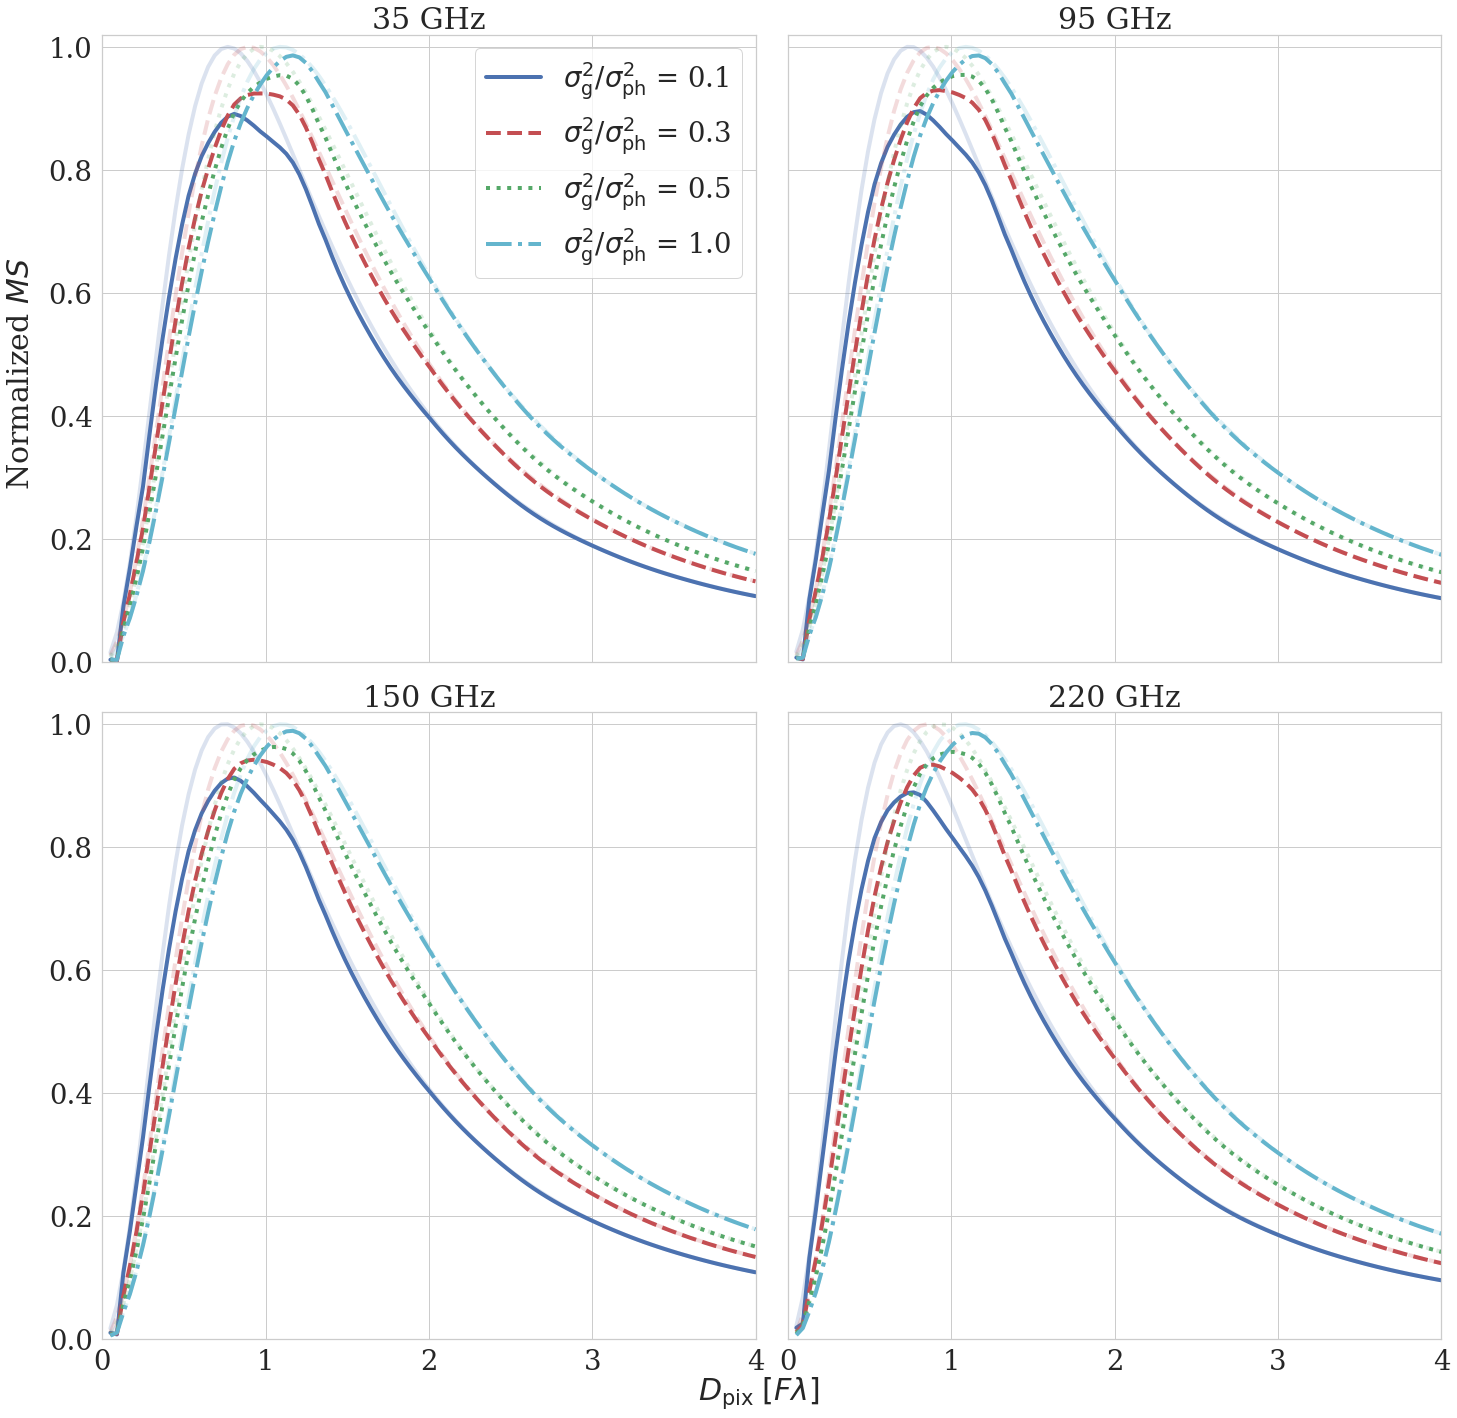

In [37]:
det_data = np.transpose(MS_arr, (1, 0, 3, 2))

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(wspace=wspace, hspace=hspace)
fig.set_figheight(24)
fig.set_figwidth(24)

for i, dat in enumerate(det_data):
    MS_plot = dat
    ind1 = i // 2
    ind2 = i % 2
    for j, nepg2_frac in enumerate(nepg2_frac_arr):
        ax[ind1][ind2].plot(spacings, MS_plot[j][0], linewidth=4,
                            label=r'$\sigma_{\mathrm{g}}^{2} / \sigma_{\mathrm{ph}}^{2}$ = %.1f' % (nepg2_frac),
                            color=colors[j], linestyle=linestyles[j])
        ax[ind1][ind2].plot(spacings, MS_plot[j][1], linewidth=4, 
                           color=colors[j], linestyle=linestyles[j], alpha=0.2)
    if i == 0:
        ax[ind1][ind2].legend()
    ax[ind1][ind2].set_ylim(0.0, 1.02)
    ax[ind1][ind2].set_xlim(0, 4)
    ax[ind1][ind2].set_title("%d GHz" % (names[i]))
fig.text(0.07, 0.62, "Normalized $MS$", rotation=90)
fig.text(0.47, 0.09, "$D_{\mathrm{pix}} \; [F \lambda]$")
plt.savefig(os.path.join("Plots", "MISC", "mapping_speed_detNoise_quad.pdf"), bbox_inches='tight')

## Impact of Telescope temperature

In [38]:
sky_T = atm_temp
sky_eff = atm_tran
tel_T_arr = [10, 20, 30, 40]
cmb_T = Tcmb
nepg2_frac = 0.1

In [39]:
MS_arr = []
for a, tel_T in enumerate(tel_T_arr):
    MS_arr_arr = []
    for i, freq in enumerate(freqs):
        fbw = fbws[i]
        MS_arr_arr_arr = []
        # Calculate sensitivity for each spacing scenario
        for j, spacing in enumerate(spacings):
            MS_corr, MS = MS_det(
                freq, fbw, spacing, F_num, w_f,
                np.array(gamma_arr[j][0]), np.array(gamma_arr[j][1]),
                atm_freq * GHz, sky_T, sky_eff, cmb_T, tel_T, Tstop, det_eff, nepg2_frac=nepg2_frac)[3:]
            MS_arr_arr_arr.append(np.array([MS_corr, MS]))
        MS_tot = np.array([MS_arr_arr_arr[j] * (1 / spacings[j])**2 for j in range(len(spacings))])
        MS_tot = MS_tot / np.amax(MS_tot)
        MS_arr_arr.append(MS_tot)
    MS_arr.append(MS_arr_arr)

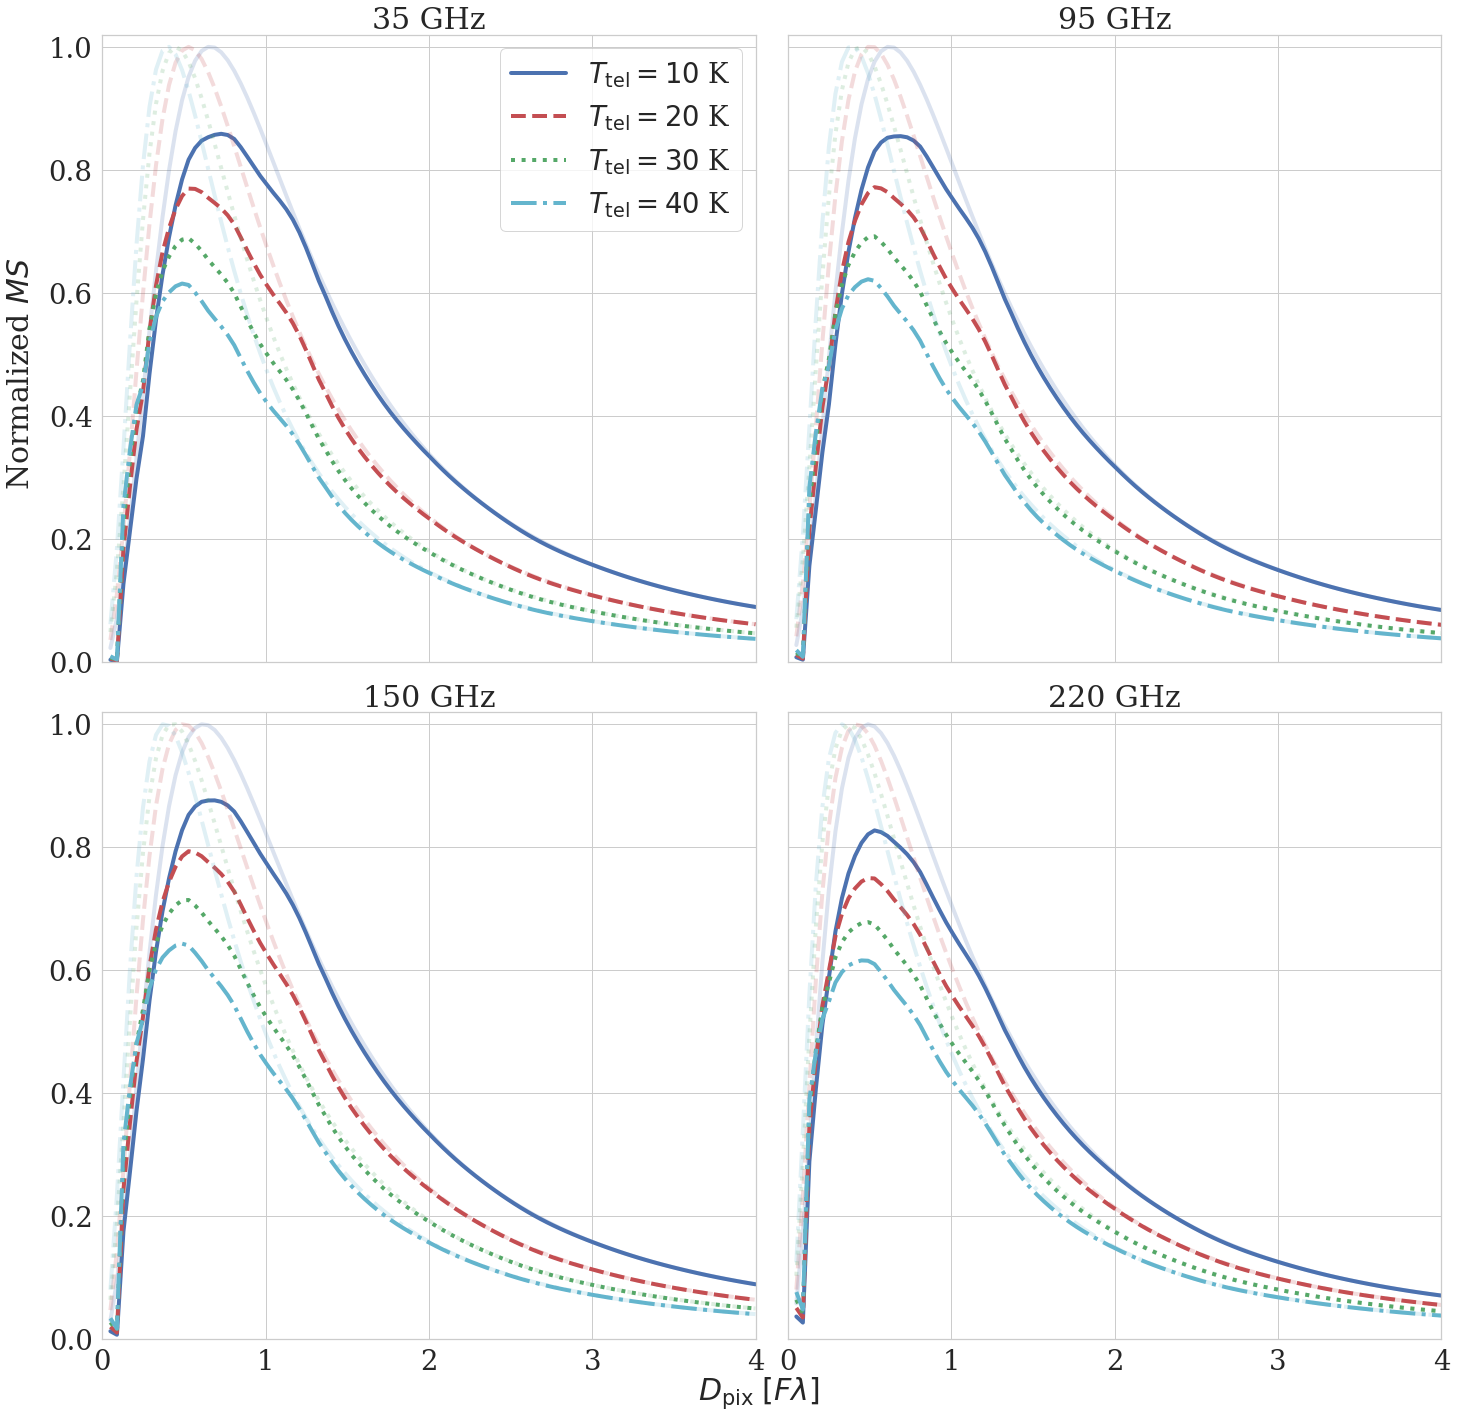

In [40]:
tel_data = np.transpose(MS_arr, (1, 0, 3, 2))

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(wspace=wspace, hspace=hspace)
fig.set_figheight(24)
fig.set_figwidth(24)

for i, dat in enumerate(tel_data):
    MS_plot = dat
    ind1 = i // 2
    ind2 = i % 2
    for j, tel_T in enumerate(tel_T_arr):
        ax[ind1][ind2].plot(spacings, MS_plot[j][0], linewidth=4,
                            label=r'$T_{\mathrm{tel}} = %d$ K' % (tel_T),
                            color=colors[j], linestyle=linestyles[j])
        ax[ind1][ind2].plot(spacings, MS_plot[j][1], linewidth=4, 
                           color=colors[j], linestyle=linestyles[j], alpha=0.2)
    if i == 0:
        ax[ind1][ind2].legend()
    ax[ind1][ind2].set_ylim(0.0, 1.02)
    ax[ind1][ind2].set_xlim(0, 4)
    ax[ind1][ind2].set_title("%d GHz" % (names[i]))
fig.text(0.07, 0.62, "Normalized $MS$", rotation=90)
fig.text(0.47, 0.09, "$D_{\mathrm{pix}} \; [F \lambda]$")
plt.savefig(os.path.join("Plots", "MISC", "mapping_speed_telT_quad.pdf"), bbox_inches='tight')

## Combined impact plot

In [41]:
data_arr = [stop_data, tel_data, det_data]
legend_title_arr = [
    "$T_{\mathrm{stop}}$",
    "$T_{\mathrm{tel}}$",
    "$\sigma_{\mathrm{int}}^{2} / \sigma_{\mathrm{ph}}^{2}$"]
label_arr = [
    ["2 K", "3 K", "4 K", "5 K"],
    ["10 K", "20 K", "30 K", "40 K"],
    ["0.1", "0.3", "0.5", "1.0"]]

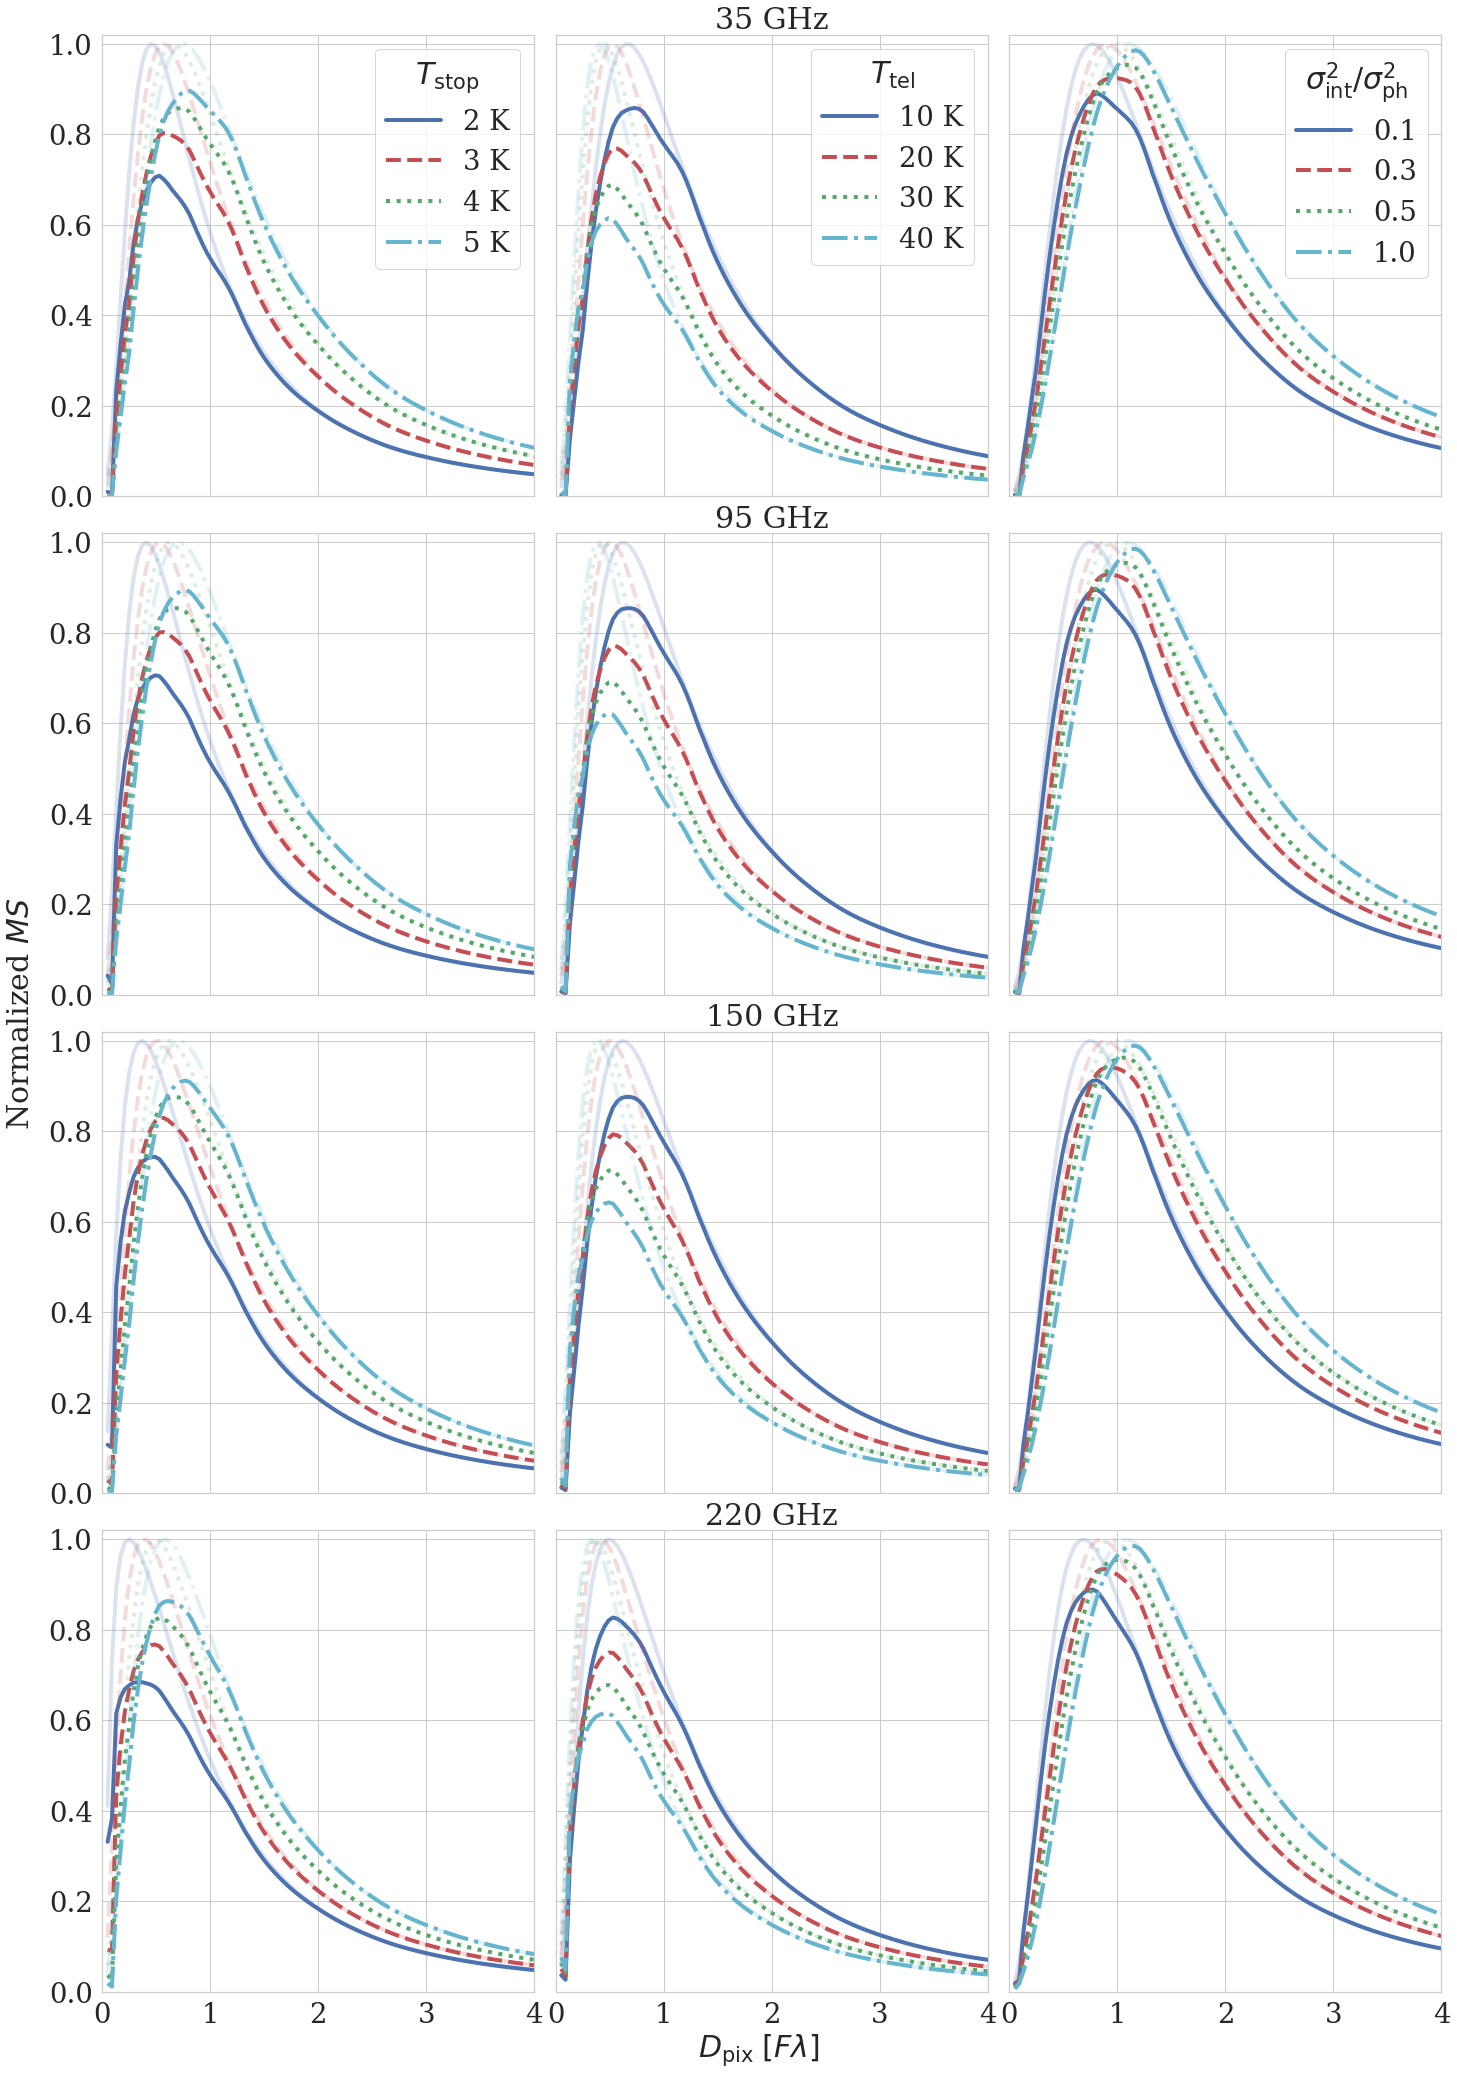

In [42]:
fig, ax = plt.subplots(4, 3, sharex=True, sharey=True)
fig.subplots_adjust(wspace=wspace, hspace=hspace)
fig.set_figheight(36)
fig.set_figwidth(24)

# Looping over columns
for i, data in enumerate(data_arr):
    # Looping over rows
    labels = label_arr[i]
    legend_title = legend_title_arr[i]
    for j, dat in enumerate(data):
        MS_plot = dat
        ind1 = j
        ind2 = i
        for k, label in enumerate(labels):
            ax[ind1][ind2].plot(spacings, MS_plot[k][0], linewidth=4,
                                label=label,
                                color=colors[k], linestyle=linestyles[k])
            ax[ind1][ind2].plot(spacings, MS_plot[k][1], linewidth=4, 
                               color=colors[k], linestyle=linestyles[k], alpha=0.2)
        if j == 0:
            ax[ind1][ind2].legend(title=legend_title)
        ax[ind1][ind2].set_ylim(0.0, 1.02)
        ax[ind1][ind2].set_xlim(0, 4)
        if i == 1:
            ax[ind1][ind2].set_title("%d GHz" % (names[j]))
fig.text(0.07, 0.46, "Normalized $MS$", rotation=90)
fig.text(0.47, 0.1, "$D_{\mathrm{pix}} \; [F \lambda]$")
plt.savefig(os.path.join("Plots", "mapping_speed_dependencies.pdf"), bbox_inches='tight')